# Location Set Covering Problem (LSCP)

*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

The Location Set Covering Problem is described by Toregas et al. (1971). There they show that emergency services must be placed according to a response time, since there is a allowable maximum service time for handling emergency activities. Therefore the LSCP model was proprosed whereby _the minimum number of facilities determined and locaten so that every demand area is covered within a predefined maximal service distance or time (Church and Murray, 2018)._ 

**LSCP can be written as:**

$\begin{array} \displaystyle \textbf{Minimize} & \sum_{j=1}^{n}{x_j} && (1) \\
\displaystyle \textbf{Subject to:} & \sum_{j\in N_i}{x_j} \geq 1 & \forall i & (2) \\
            & x_j \in {0,1} & \forall j & (3) \\ \end{array}$
            
$\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing nodes of the network as demand} \\
& & j & \small = & \textrm{index referencing nodes of the network as potential facility sites} \\
& & S & \small = & \textrm{maximal acceptable service distance or time standard} \\
& & d_{ij} & \small = & \textrm{shortest distance or travel time between nodes } i \textrm{ and } j \\
& & N_i & \small = & \{j | d_{ij} < S\} \\
& & x_j & \small = & \begin{cases} 
          1, \text{if a facility is located at node } j\\
          0, \text{otherwise} \\
       \end{cases} \end{array}$
       
_The formulation above is from Church and Murray (2018)._

This tutorial solves generates synthetic demand (clients) and facility sites near a 10x10 lattice representing a gridded urban core. Three LSCP instances are solved while varying parameters:
* `LSCP.from_cost_matrix()` with network distance as the metric
* `LSCP.from_geodataframe()` with euclidean distance as the metric
* `LSCP.from_geodataframe()` with predefined facility locations and euclidean distance as the metric

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-18T23:36:35.628808-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import numpy
import pulp
import shapely
from shapely.geometry import Point
import spaghetti
import spopt
from spopt.locate.coverage import LSCP
from spopt.locate.util import simulated_geo_points

%watermark -w
%watermark -iv

/Users/the-gaboardi/miniconda3/envs/py310_spopt/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


Watermark: 2.3.1

matplotlib: 3.6.1
json      : 2.0.9
spopt     : 0.4.1+200.g336f235.dirty
geopandas : 0.11.1
spaghetti : 1.6.7
numpy     : 1.23.3
pulp      : 2.6.0
shapely   : 1.8.5



Since the model needs a cost matrix (distance, time, etc.) we should define some variables. First we will assign some the number of clients and facility locations, then the maximum service radius, followed by random seeds in order to reproduce the results. Finally, the solver, assigned below as `pulp.PULP_CBC_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface, such as Gurobi or CPLEX, see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [3]:
CLIENT_COUNT = 100  # quantity demand points
FACILITY_COUNT = 10  # quantity supply points

SERVICE_RADIUS = 8  # maximum service radius (in distance units)

# Random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

## Lattice 10x10

Create a 10x10 lattice with 9 interior lines, both vertical and horizontal.

In [4]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform the `spaghetti` instance into geodataframe.

In [5]:
streets = spaghetti.element_as_gdf(ntw, arcs=True)

In [6]:
streets_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(streets["geometry"].buffer(0.5).unary_union),
    crs=streets.crs,
    columns=["geometry"],
)

Plotting the network created by `spaghetti` we can verify that it mimics a district with quarters and streets.

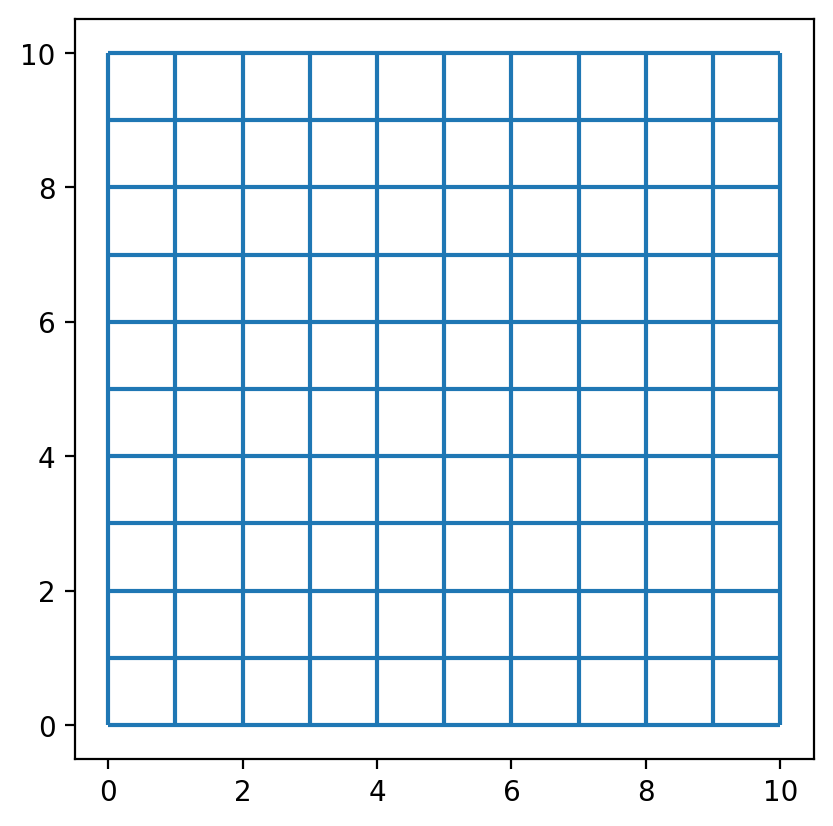

In [7]:
streets.plot();

## Simulate points in a network

The `simulated_geo_points` function simulates points near a network. In this case, it uses the 10x10 lattice network created using the `spaghetti` package. Below we use the function defined above and simulate the points near the lattice edges.

In [8]:
client_points = simulated_geo_points(
    streets_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED
)
facility_points = simulated_geo_points(
    streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client and 10 facility points we can see that the function generates dummy points to an area of 10x10, which is the area created by our lattice created on previous cells.

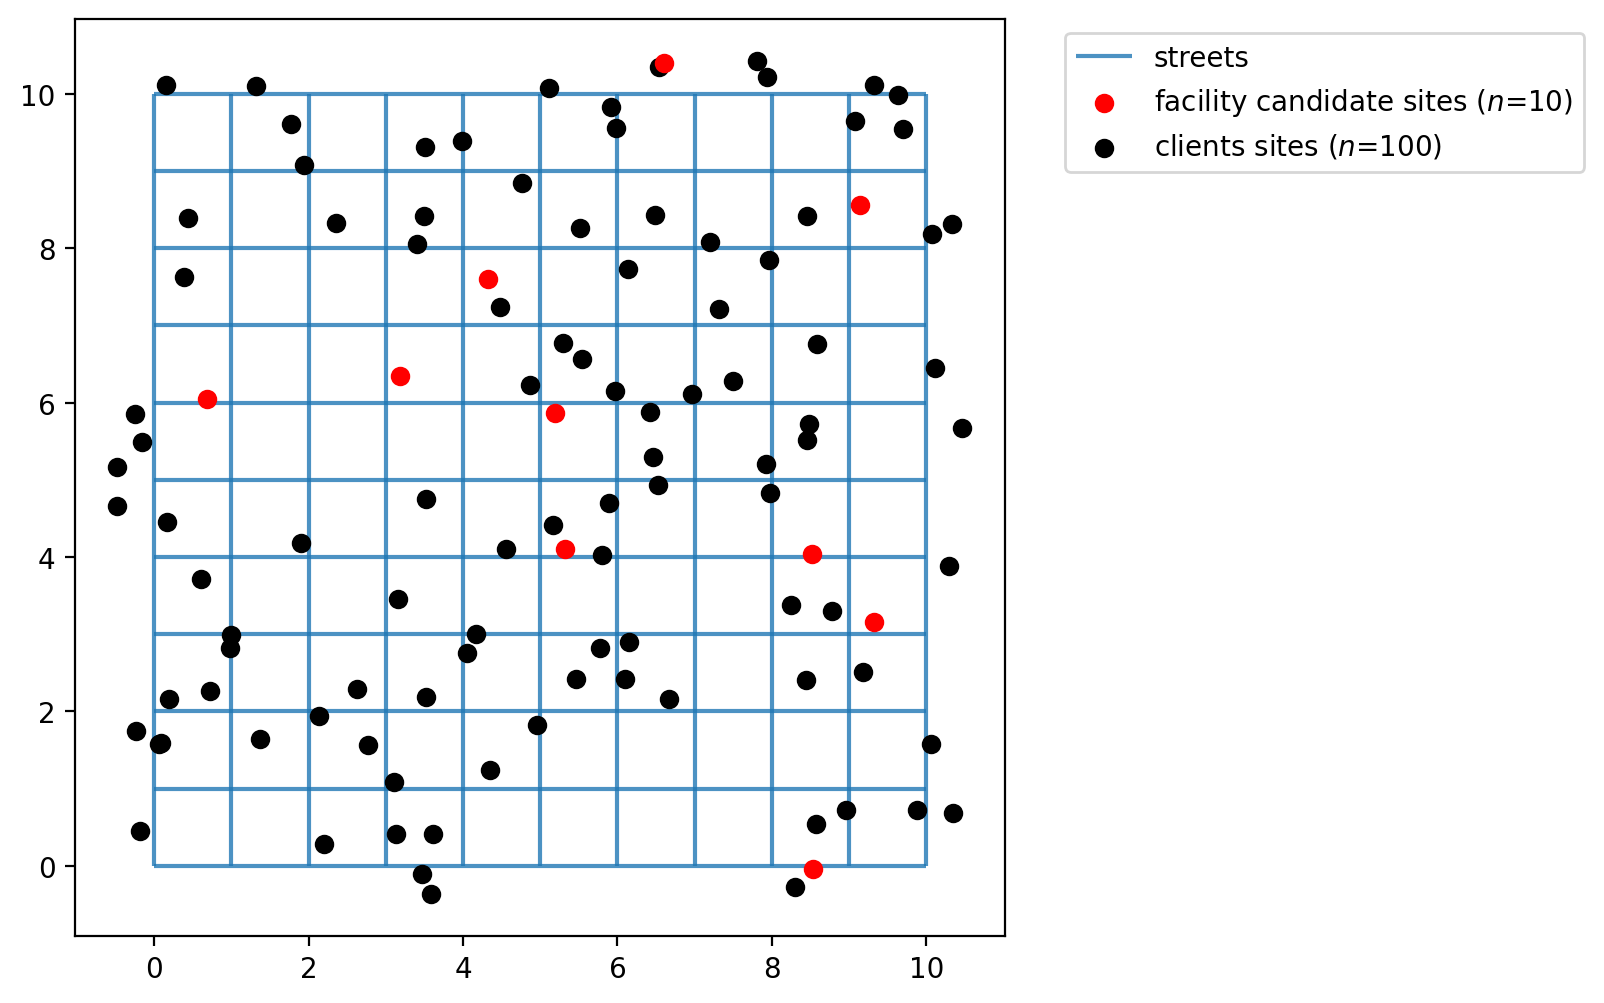

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
client_points.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Assign simulated points network locations

The simulated client and facility points do not ahere to network space. Calculating distances between them without restricting movement to the network results in a euclidean distances,'as the crow flies.' While this is acceptable for some applications, for others it is more realistic to consider network traversal (e.g. Does a mail carrier follow roads to deliver letters or fly from mailbox to mailbox?).

In our first example we will consider distance along the 10x10 lattice network created above. Therefore, we must first snap the observation points to the network prior to calculating a cost matrix.

In [10]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

Now the plot seems more organized as the points occupy network space. The network is plotted below with the network locations of the facility points and clients points.

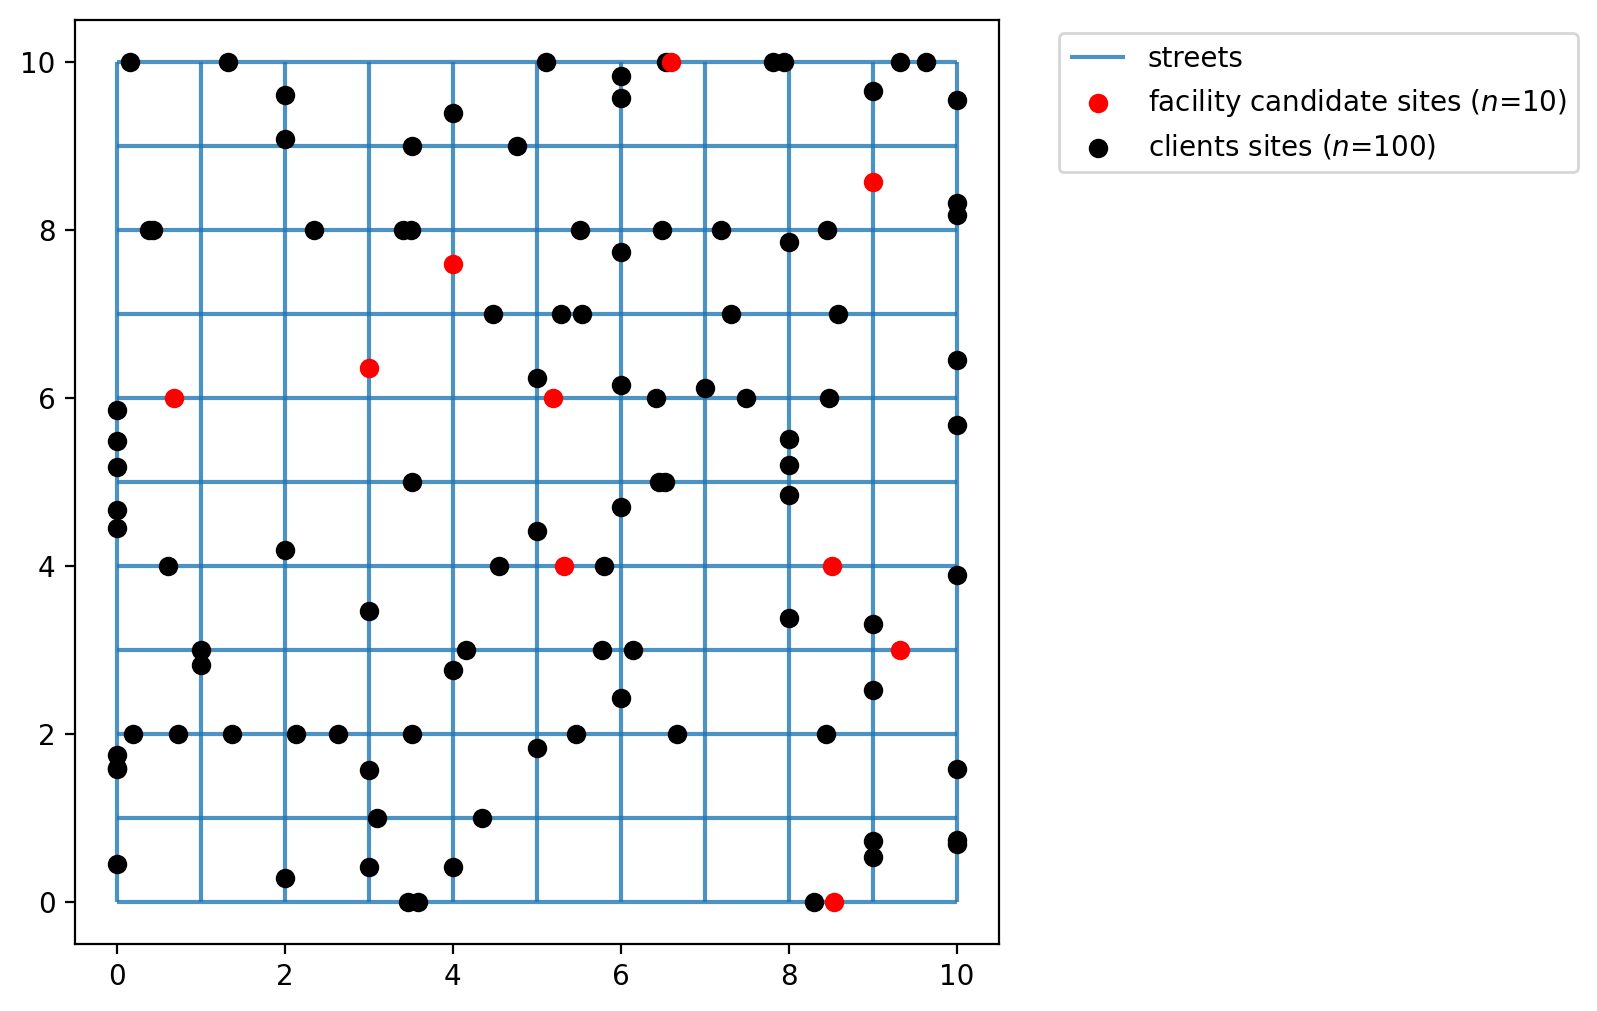

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
clients_snapped.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

## Calculating the (network distance) cost matrix
Calculate the network distance between clients and facilities.

In [12]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

The expected result here is a network distance between clients and facilities points, in our case a 2D 100x10 array.

In [13]:
cost_matrix.shape

(100, 10)

In [14]:
cost_matrix[:5,:]

array([[13.39951703, 15.61157572,  4.39383189,  8.40604635,  3.73034161,
         3.4833522 ,  6.2764559 ,  5.52085069, 11.59649553,  7.51670161],
       [13.92618165, 16.13824034,  4.92049651,  8.93271097,  4.25700623,
         4.01001682,  6.80312052,  4.99418607, 12.12316015,  8.04336623],
       [ 7.55064416,  9.76270285,  4.54495901,  2.55717348,  2.57689625,
         2.36552068,  0.42758302,  5.36972356,  5.74762266,  6.33217127],
       [ 3.52405953,  5.73611822,  8.11317865,  3.87460688,  6.14511589,
         6.3921053 ,  3.5990016 ,  6.19849608,  1.72103803,  4.35875589],
       [ 7.75652815,  7.09845387,  6.75084301,  4.76305747,  4.78278024,
         7.02976965,  6.63346702, 12.03397254,  7.95350665, 12.99642024]])

In [15]:
cost_matrix[-5:,:]

array([[ 4.82677859,  7.03883728,  6.8104596 ,  4.16669209,  4.84239683,
         5.08938625,  2.29628254,  4.89577702,  3.02375709,  4.06667068],
       [ 6.47650911,  8.6885678 ,  5.47082397,  2.82705646,  3.5027612 ,
         3.43965572,  0.95664692,  4.44385861,  4.67348761,  5.40630631],
       [10.9188216 , 13.13088029,  4.71841659,  5.92535092,  2.05492631,
         1.00265676,  3.79576046,  5.19626599,  9.1158001 ,  6.15871369],
       [ 3.17082521,  5.3828839 ,  8.46641298,  1.82264547,  6.49835021,
         6.74533963,  3.95223592,  7.74954251,  3.36780371,  8.4107173 ],
       [10.03753584,  6.81744618,  7.0318507 ,  7.04406516,  7.06378793,
         9.31077734,  8.91447471, 14.31498023, 10.23451434, 15.27742793]])

With ``LSCP.from_cost_matrix`` we model the LSCP problem to cover all demand points within `SERVICE_RADIUS` distance units using the network distance cost matrix calculated above.

In [16]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, SERVICE_RADIUS)

In [17]:
lscp_from_cost_matrix = lscp_from_cost_matrix.solve(solver)

Expected result is an instance of LSCP.

In [18]:
lscp_from_cost_matrix

Define the decision variable names used for mapping later.

In [19]:
facility_points["dv"] = lscp_from_cost_matrix.fac_vars
facility_points["dv"] = facility_points["dv"].map(
    lambda x: x.name.replace("_", "").replace("x", "y")
)
facilities_snapped["dv"] = facility_points["dv"]
facility_points

,geometry,dv
0,POINT (9.32146 3.15178),y0
1,POINT (8.53352 -0.04134),y1
2,POINT (0.68422 6.04557),y2
3,POINT (5.32799 4.10688),y3
4,POINT (3.18949 6.34771),y4
5,POINT (4.31956 7.59470),y5
6,POINT (5.19840 5.86744),y6
7,POINT (6.59891 10.39247),y7
8,POINT (8.51844 4.04521),y8
9,POINT (9.13894 8.56135),y9


## Calculating euclidean distance from a `GeoDataFrame`

With ``LSCP.from_geodataframe`` we model the LSCP problem to cover all demand points within `SERVICE_RADIUS` distance units using geodataframes to calculate a euclidean distance cost matrix.

Next we will solve the LSCP considering all 10 candidate locations for potential selection.

In [20]:
lscp_from_geodataframe = LSCP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    SERVICE_RADIUS,
    distance_metric="euclidean",
)

In [21]:
lscp_from_geodataframe = lscp_from_geodataframe.solve(solver)

Expected result is an instance of LSCP.

In [22]:
lscp_from_geodataframe

However, in many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define facilites `'y4'` and `'y9'` as already existing (they must be present in the model solution). This will lead to a sub-optimal solution.

In [23]:
facilities_snapped["predefined_loc"] = numpy.array([0, 0, 0, 0, 1]*2)
facilities_snapped

,geometry,dv,predefined_loc
0,POINT (9.32146 3.00000),y0,0
1,POINT (8.53352 0.00000),y1,0
2,POINT (0.68422 6.00000),y2,0
3,POINT (5.32799 4.00000),y3,0
4,POINT (3.00000 6.34771),y4,1
5,POINT (4.00000 7.59470),y5,0
6,POINT (5.19840 6.00000),y6,0
7,POINT (6.59891 10.00000),y7,0
8,POINT (8.51844 4.00000),y8,0
9,POINT (9.00000 8.56135),y9,1


In [24]:
lscp_preselected_from_geodataframe = LSCP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    SERVICE_RADIUS,
    predefined_facility_col="predefined_loc",
    distance_metric="euclidean",
)

In [25]:
lscp_preselected_from_geodataframe = lscp_preselected_from_geodataframe.solve(solver)

## Plotting the results

The two cells below describe the plotting of the results. For each method from LSCP class (`.from_cost_matrix()`, `.from_geodataframe()`) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color. Demand points covered by more than one facility are displayed in overlapping concentric circles.

In [26]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [27]:
def plot_results(model, facility_points):
    
    p = model.problem.objective.value()
    cli_sites = {}
    fac_sites = []
    legend_elements = []
    
    # isolate selected facilites and associated clients
    for i in facility_points.index:
        if model.fac2cli[i]:
            geom = client_points.iloc[model.fac2cli[i]]["geometry"]
            cli_sites[facility_points.loc[i, "dv"]] = geom
            fac_sites.append(i)
    # plot streets and add legend entry
    ax = streets.plot(figsize=(6, 6), alpha=1, color="black", zorder=1)
    legend_elements.append(
        mlines.Line2D(
            [],
            [],
            color="black",
            label="streets",
        )
    )
    # plot all candidate facilities and add legend entry
    facility_points.plot(ax=ax, color="brown", marker="*", markersize=80, zorder=2)
    legend_elements.append(
        mlines.Line2D(
            [],
            [],
            color="brown",
            marker="*",
            linewidth=0,
            label=f"facility sites ($n$={FACILITY_COUNT})",
        )
    )
    
    #
    _zo, _ms = 4, 4
    for i, (fname, geoms) in enumerate(cli_sites.items()):
        cset = dv_colors[fname]
        fac = fac_sites[i]
        gdf = geopandas.GeoDataFrame(geoms)

        # plot clients associated with facility [i] and add legend entry
        gdf.plot(ax=ax, zorder=_zo, ec="k", fc=cset, markersize=100 * _ms)
        label = f"Demand sites covered by {fname}"
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="o",
                markerfacecolor=cset,
                markeredgecolor="k",
                ms=_ms + 7,
                lw=0,
                label=label,
            )
        )
        # plot selected facility [i] and add legend entry
        facility_points.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec="k", lw=2
        )
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="*",
                markerfacecolor=cset,
                markeredgecolor="k",
                markeredgewidth=2,
                ms=20,
                lw=0,
                label=fname,
            )
        )
        # increment client zorder and markersizes
        _zo += 1
        _ms -= (1) * (5 / p)

    plt.title("LSCP", fontweight="bold")
    plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 1))

### LSCP built from cost matrix (network distance)

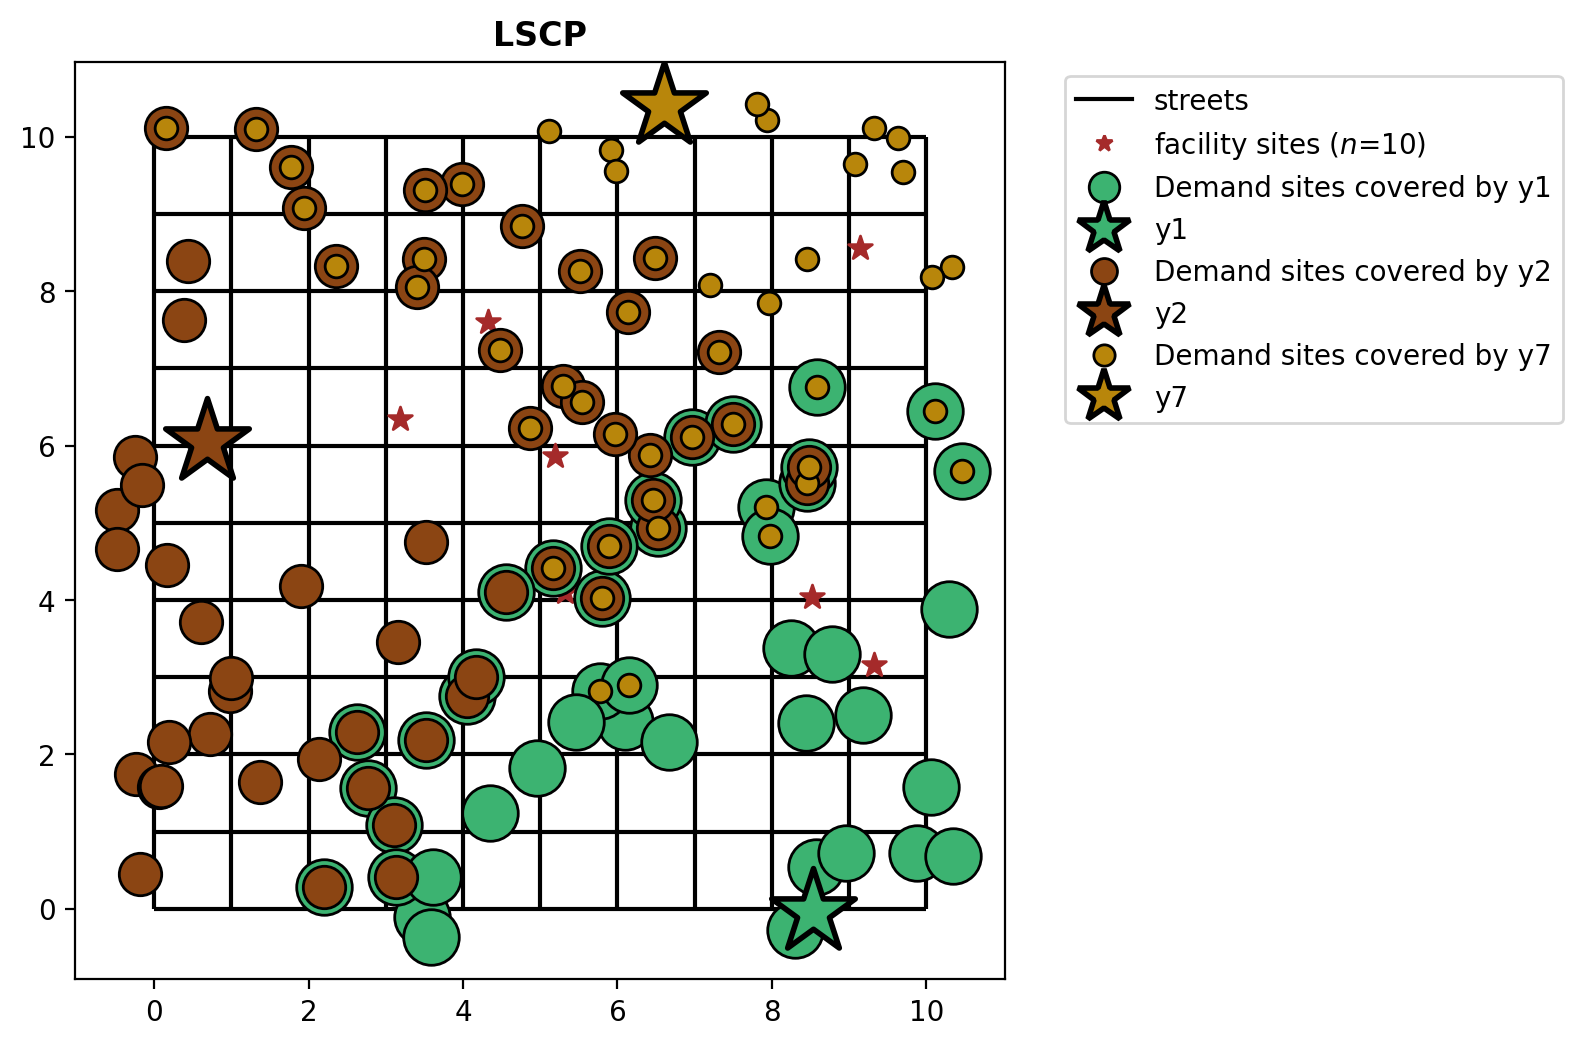

In [28]:
plot_results(lscp_from_cost_matrix, facility_points.reset_index())

### LSCP built from geodataframe (euclidean distance)

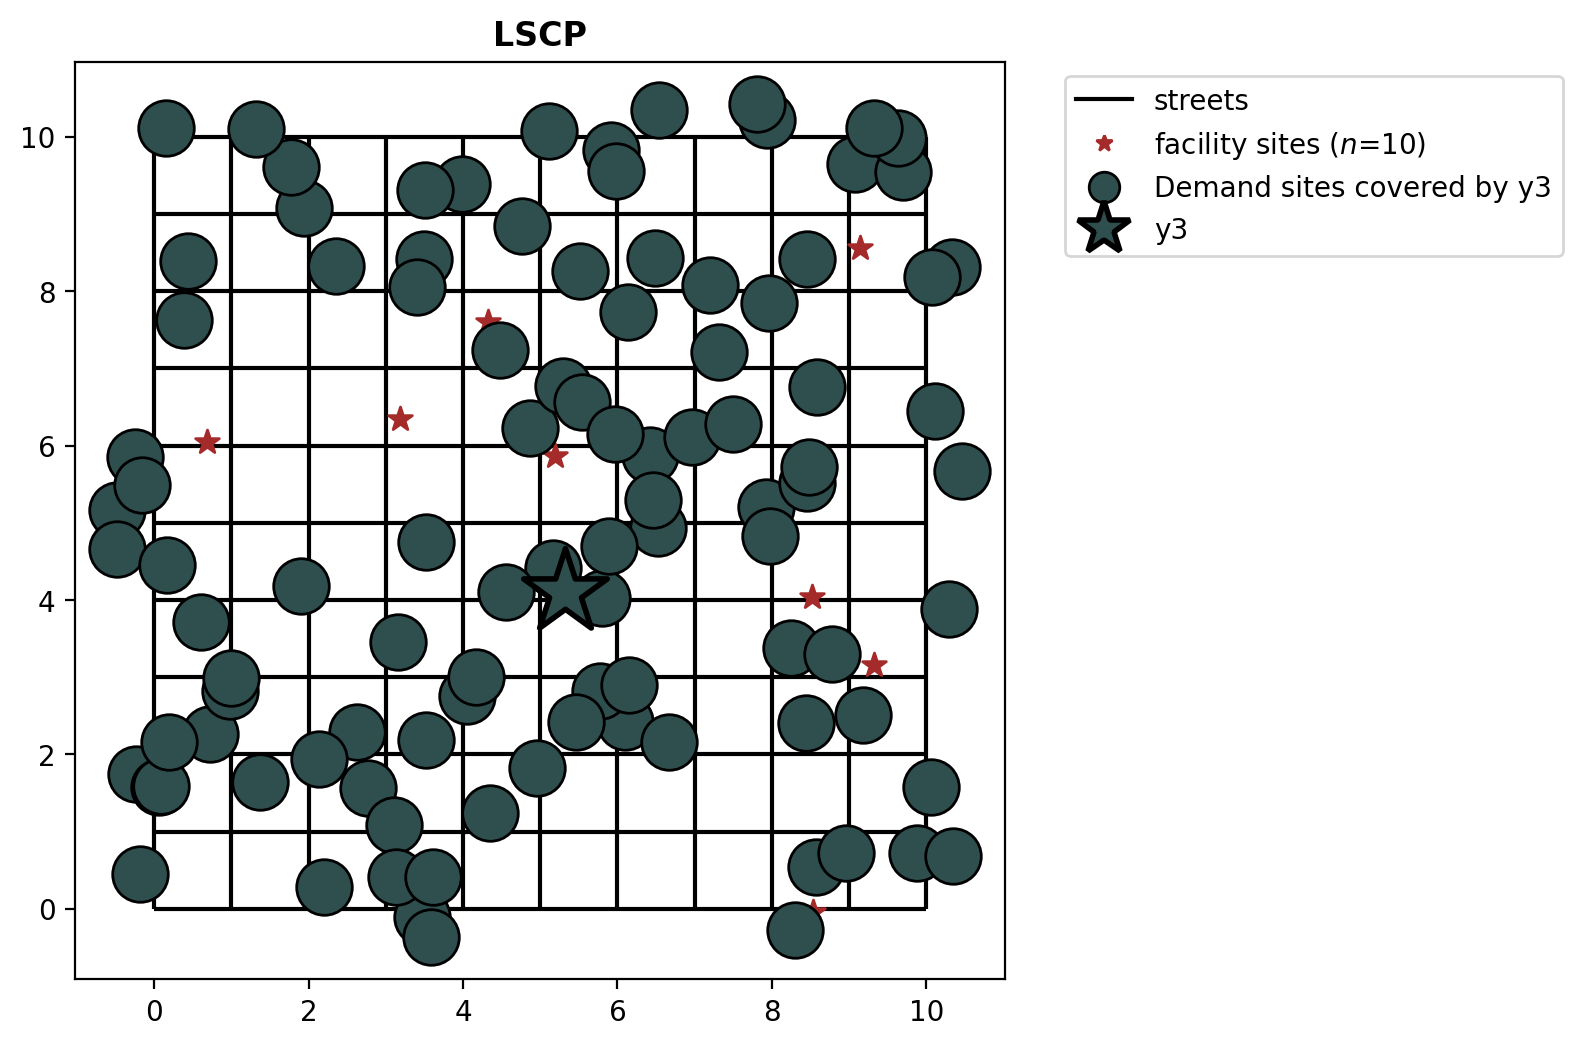

In [29]:
plot_results(lscp_from_geodataframe, facility_points.reset_index())

You may notice that the model results are very different. This is expected as the distances between facility and demand points are calculated with different metrics (network vs. euclidean distance).

But how can just one facility cover all of the demand locations? This can be explained by the nature of the problem. The problem was configured in a synthetic manner, the streets are created as a 10x10 lattice and the `SERVICE_RADIUS` parameter is 8 (distance units). Owing to the central location of facility `'y3'`, all demand points can be reached within that (euclidean) distance.

### LSCP with preselected facilities (euclidean distance)

Finally, let's visualize the results of the LSCP when stipulating that facilities `'y4'` and `'y9'` must be included in the final selection.

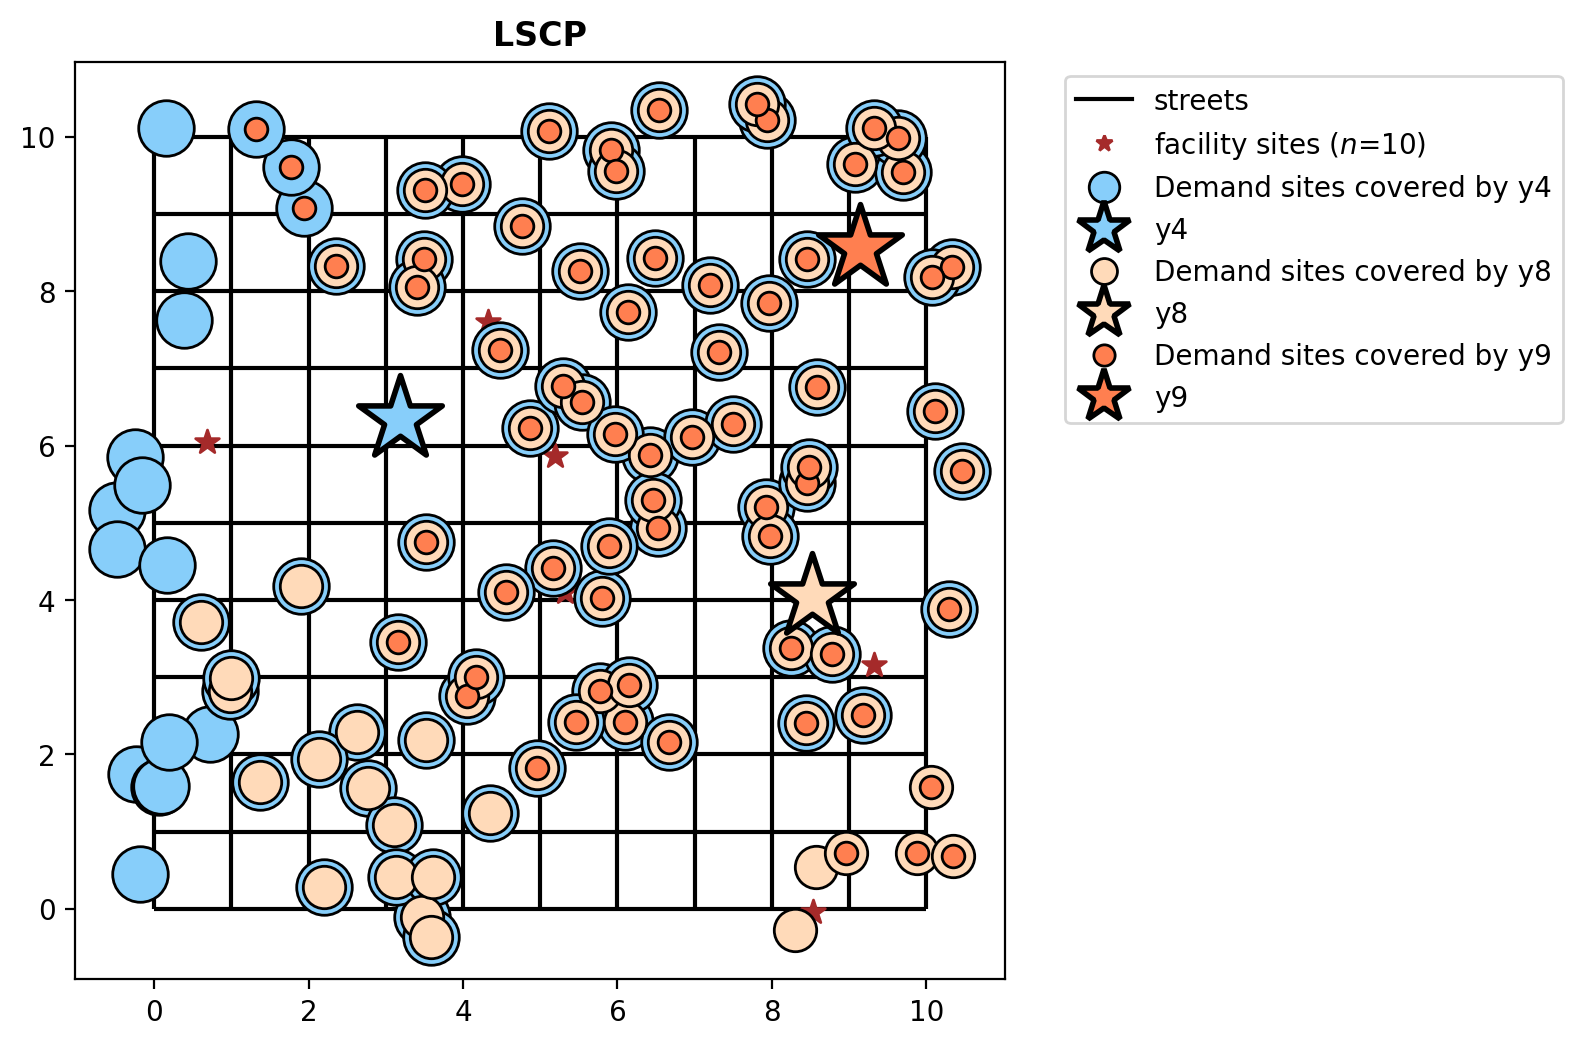

In [30]:
plot_results(lscp_preselected_from_geodataframe, facility_points.reset_index())

## References

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)
- [Toregas, C., Swain, R., ReVelle, C., &amp; Bergman, L. (1971). The location of emergency service facilities. Operations Research, 19(6), 1363–1373.](https://pubsonline.informs.org/doi/abs/10.1287/opre.19.6.1363)